In [36]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout
from sklearn.model_selection import train_test_split as splitter
import cProfile
import pstats
import os
import sys
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import KFold
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

print("Librerie importate con successo")

Librerie importate con successo


In [37]:
data = pd.read_csv('../Datasets/kdd_prediction.csv', delimiter=',',
                       dtype={'protocol_type': str, 'service': str, 'flag': str, 'result': str})

print("Dataset importato con successo")

Dataset importato con successo


Total :  13451
Normal :  7500
Malicious :  5951


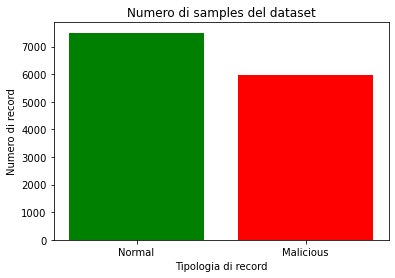

In [38]:
#Effettuo il plot del dataset

total_flows_count = data["result"].count()
normal_flows_count = len(data[data.result == "normal"])
anomaly_flows_count = len(data[data.result != "normal"])

print("Total : ",total_flows_count)
print("Normal : ",normal_flows_count)
print("Malicious : ",anomaly_flows_count)

# x-coordinates of left sides of bars  
left = [1, 1.5] 
  
# heights of bars 
height = [normal_flows_count, anomaly_flows_count] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['green', 'red']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset') 
  
plt.show() 

In [39]:
#Funzioni utili preprocessing

#ottiene una service_list dal file service.txt prelevando ogni riga e inserendola in una lista
def get_service_list(dirname='list', filename='service_mio.txt'):
    print('Getting service list...')
    with open(os.path.join(dirname, filename), 'r') as service:
        service_list = service.read().split('\n')
    return service_list

#ottiene una flag_list dal file flag.txt prelevando ogni riga e inserendola in una lista
def get_flag_list(dirname='list', filename='flag_mio.txt'):
    print('Getting flag list...')
    with open(os.path.join(dirname, filename), 'r') as flag:
        flag_list = flag.read().split('\n')
    return flag_list

In [40]:
service_list = get_service_list(dirname='list', filename='service_mio.txt')
flag_list = get_flag_list(dirname='list', filename='flag_mio.txt')

print('Replacing protocol_type values to numeric...')
data.protocol_type.replace(['tcp', 'udp', 'icmp'], range(3), inplace=True)

print('Replacing service values to numeric...')
data.service.replace(service_list, range(len(service_list)), inplace=True)

print('Replacing flag values to numeric...')
data.flag.replace(flag_list, range(len(flag_list)), inplace=True)
data.result.replace(['dos','normal','probe','r2l','u2r'], range(5), inplace=True)

Getting service list...
Getting flag list...
Replacing protocol_type values to numeric...
Replacing service values to numeric...
Replacing flag values to numeric...


In [41]:
sc = MinMaxScaler()
enc = OneHotEncoder(categories=[range(3), range(len(service_list)), range(len(flag_list))])
num_desc = data.loc[:, ['duration', 'src_bytes', 'dst_bytes']].describe()

label, df_label = [], []
    
label = data['result'].copy().values.reshape((data.shape[0], 1))
df_label = pd.DataFrame(label)
data.drop(['result'], axis=1, inplace=True)   

attr_name = ['duration', '', '', '', 'src_bytes', 'dst_bytes']

for i in ['duration', 'src_bytes', 'dst_bytes']:
    iqr = (num_desc[i].values[6] - num_desc[i].values[4])
    std = num_desc[i].values[6] + iqr * 1.5  # IQR upper fence = Q3 + 1.5 * IQR
    if std == 0:
        data[i] = data[i].map(lambda x: 1 if x > 0 else 0)
    else:
        data[i] = data[i].map(lambda x: std if x > std else x)
sc.fit(data[['duration', 'src_bytes', 'dst_bytes']].values)
data[['duration', 'src_bytes', 'dst_bytes']] = sc.transform(data[['duration', 'src_bytes', 'dst_bytes']].values)

print('Conversione feature "count" in linguaggio macchina . . .')
sc.fit(data[['count']].values.astype(np.float32))
data[['count']] = sc.transform(data[['count']].values.astype(np.float32))

print('Conversione indici 1,2,3 in linguaggio macchina . . .')
enc.fit(data[['protocol_type','service','flag']].values)
one_hot_arr = enc.transform(data[['protocol_type','service','flag']].values).toarray()

print('Rimuovo le features di indici 1,2,3 e concateno un hot encoder array')
data.drop(['protocol_type','service','flag'], axis=1, inplace=True)
data_final = np.concatenate((data.values, one_hot_arr, df_label), axis=1)
data_final = pd.DataFrame(data_final)

print("")
print("")
print('Final shape of data:', data_final.shape)
print("")
print("")

Conversione feature "count" in linguaggio macchina . . .
Conversione indici 1,2,3 in linguaggio macchina . . .
Rimuovo le features di indici 1,2,3 e concateno un hot encoder array


Final shape of data: (13451, 95)




Il dataset per il train è composto da :  12105 record
Peso associato alla classe 0, Dos: 0.54
Peso associato alla classe 1, Normal: 0.36
Peso associato alla classe 2, Probe: 5.03
Peso associato alla classe 3, R2L: 6.88
Peso associato alla classe 4, U2R: 56.30
Epoch 1/30
48/48 [==============================] - 6s 127ms/step - loss: 5.3130 - accuracy: 0.3090 - val_loss: 3.1478 - val_accuracy: 0.8950
Epoch 2/30
48/48 [==============================] - 6s 126ms/step - loss: 2.4925 - accuracy: 0.7712 - val_loss: 1.8102 - val_accuracy: 0.5850
Epoch 3/30
48/48 [==============================] - 6s 126ms/step - loss: 1.7372 - accuracy: 0.8579 - val_loss: 0.9047 - val_accuracy: 0.9450
Epoch 4/30
48/48 [==============================] - 6s 125ms/step - loss: 1.2589 - accuracy: 0.8885 - val_loss: 0.8587 - val_accuracy: 0.9200
Epoch 5/30
48/48 [==============================] - 7s 137ms/step - loss: 1.0110 - accuracy: 0.9027 - val_loss: 0.5882 - val_accuracy: 0.9300
Epoch 6/30
48/48 [============

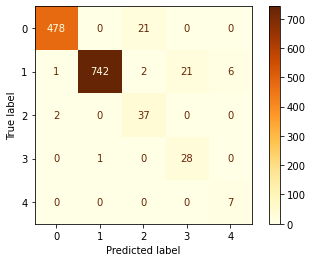

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       499
           1       1.00      0.96      0.98       772
           2       0.62      0.95      0.75        39
           3       0.57      0.97      0.72        29
           4       0.54      1.00      0.70         7

    accuracy                           0.96      1346
   macro avg       0.74      0.97      0.82      1346
weighted avg       0.97      0.96      0.96      1346

### 0 Anomaly / 1 Normal ###


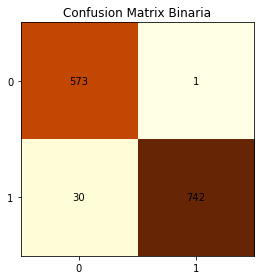

          predicted labels  
0 :
             precision:  0.950
             recall:     0.998


1 :
             precision:  0.999
             recall:     0.961


Avg precision:     0.974
Avg weight precision:     0.978
Avg recall:     0.980
Avg weight recall:     0.977

Accuracy:  0.97697
Il dataset per il train è composto da :  12106 record
Peso associato alla classe 0, Dos: 0.54
Peso associato alla classe 1, Normal: 0.36
Peso associato alla classe 2, Probe: 5.07
Peso associato alla classe 3, R2L: 7.06
Peso associato alla classe 4, U2R: 52.63
Epoch 1/30
48/48 [==============================] - 7s 136ms/step - loss: 5.2073 - accuracy: 0.4397 - val_loss: 2.7467 - val_accuracy: 0.5550
Epoch 2/30
48/48 [==============================] - 6s 134ms/step - loss: 2.5538 - accuracy: 0.7807 - val_loss: 1.7815 - val_accuracy: 0.9300
Epoch 3/30
48/48 [==============================] - 6s 131ms/step - loss: 1.6888 - accuracy: 0.8769 - val_loss: 1.4752 - val_accuracy: 0.8500
Epoch 4/30
48/48 [===

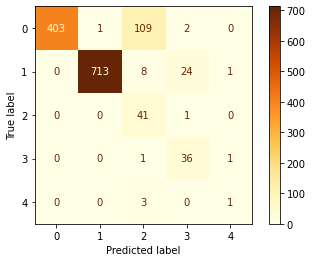

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       1.00      0.78      0.88       515
           1       1.00      0.96      0.98       746
           2       0.25      0.98      0.40        42
           3       0.57      0.95      0.71        38
           4       0.33      0.25      0.29         4

    accuracy                           0.89      1345
   macro avg       0.63      0.78      0.65      1345
weighted avg       0.96      0.89      0.91      1345

### 0 Anomaly / 1 Normal ###


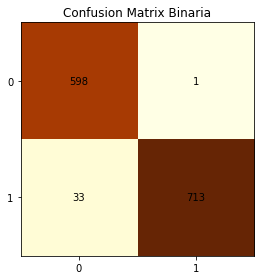

          predicted labels  
0 :
             precision:  0.948
             recall:     0.998


1 :
             precision:  0.999
             recall:     0.956


Avg precision:     0.973
Avg weight precision:     0.976
Avg recall:     0.977
Avg weight recall:     0.975

Accuracy:  0.97472
Il dataset per il train è composto da :  12106 record
Peso associato alla classe 0, Dos: 0.54
Peso associato alla classe 1, Normal: 0.36
Peso associato alla classe 2, Probe: 5.23
Peso associato alla classe 3, R2L: 7.29
Peso associato alla classe 4, U2R: 53.80
Epoch 1/30
48/48 [==============================] - 7s 141ms/step - loss: 5.4045 - accuracy: 0.5522 - val_loss: 3.9048 - val_accuracy: 0.5900
Epoch 2/30
48/48 [==============================] - 6s 131ms/step - loss: 2.9286 - accuracy: 0.8404 - val_loss: 1.7718 - val_accuracy: 0.9350
Epoch 3/30
48/48 [==============================] - 7s 136ms/step - loss: 2.0346 - accuracy: 0.8807 - val_loss: 1.1819 - val_accuracy: 0.9350
Epoch 4/30
48/48 [===

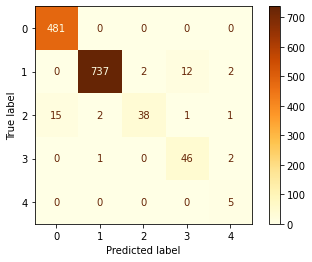

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       481
           1       1.00      0.98      0.99       753
           2       0.95      0.67      0.78        57
           3       0.78      0.94      0.85        49
           4       0.50      1.00      0.67         5

    accuracy                           0.97      1345
   macro avg       0.84      0.92      0.85      1345
weighted avg       0.97      0.97      0.97      1345

### 0 Anomaly / 1 Normal ###


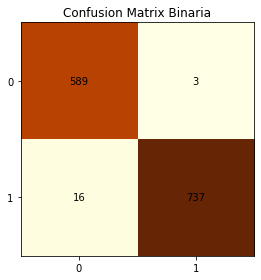

          predicted labels  
0 :
             precision:  0.974
             recall:     0.995


1 :
             precision:  0.996
             recall:     0.979


Avg precision:     0.985
Avg weight precision:     0.986
Avg recall:     0.987
Avg weight recall:     0.986

Accuracy:  0.98587
Il dataset per il train è composto da :  12106 record
Peso associato alla classe 0, Dos: 0.53
Peso associato alla classe 1, Normal: 0.36
Peso associato alla classe 2, Probe: 5.27
Peso associato alla classe 3, R2L: 7.02
Peso associato alla classe 4, U2R: 55.03
Epoch 1/30
48/48 [==============================] - 7s 136ms/step - loss: 5.2340 - accuracy: 0.4199 - val_loss: 3.3468 - val_accuracy: 0.2650
Epoch 2/30
48/48 [==============================] - 6s 134ms/step - loss: 3.0023 - accuracy: 0.7163 - val_loss: 1.6625 - val_accuracy: 0.9600
Epoch 3/30
48/48 [==============================] - 6s 131ms/step - loss: 1.7074 - accuracy: 0.8560 - val_loss: 0.8825 - val_accuracy: 0.9400
Epoch 4/30
48/48 [===

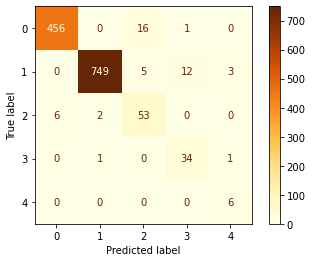

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       473
           1       1.00      0.97      0.98       769
           2       0.72      0.87      0.79        61
           3       0.72      0.94      0.82        36
           4       0.60      1.00      0.75         6

    accuracy                           0.97      1345
   macro avg       0.80      0.95      0.86      1345
weighted avg       0.97      0.97      0.97      1345

### 0 Anomaly / 1 Normal ###


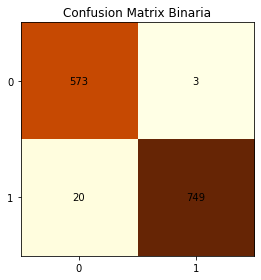

          predicted labels  
0 :
             precision:  0.966
             recall:     0.995


1 :
             precision:  0.996
             recall:     0.974


Avg precision:     0.981
Avg weight precision:     0.983
Avg recall:     0.984
Avg weight recall:     0.983

Accuracy:  0.98290
Il dataset per il train è composto da :  12106 record
Peso associato alla classe 0, Dos: 0.54
Peso associato alla classe 1, Normal: 0.36
Peso associato alla classe 2, Probe: 5.18
Peso associato alla classe 3, R2L: 7.21
Peso associato alla classe 4, U2R: 56.31
Epoch 1/30
48/48 [==============================] - 7s 136ms/step - loss: 5.0780 - accuracy: 0.4271 - val_loss: 3.5884 - val_accuracy: 0.5900
Epoch 2/30
48/48 [==============================] - 6s 132ms/step - loss: 2.8341 - accuracy: 0.8347 - val_loss: 1.6363 - val_accuracy: 0.9400
Epoch 3/30
48/48 [==============================] - 7s 137ms/step - loss: 1.7767 - accuracy: 0.8825 - val_loss: 1.6544 - val_accuracy: 0.6150
Epoch 4/30
48/48 [===

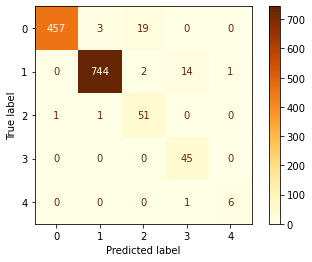

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       1.00      0.95      0.98       479
           1       0.99      0.98      0.99       761
           2       0.71      0.96      0.82        53
           3       0.75      1.00      0.86        45
           4       0.86      0.86      0.86         7

    accuracy                           0.97      1345
   macro avg       0.86      0.95      0.90      1345
weighted avg       0.98      0.97      0.97      1345

### 0 Anomaly / 1 Normal ###


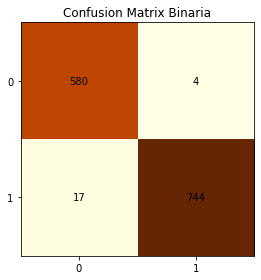

          predicted labels  
0 :
             precision:  0.972
             recall:     0.993


1 :
             precision:  0.995
             recall:     0.978


Avg precision:     0.983
Avg weight precision:     0.985
Avg recall:     0.985
Avg weight recall:     0.984

Accuracy:  0.98439
Il dataset per il train è composto da :  12106 record
Peso associato alla classe 0, Dos: 0.54
Peso associato alla classe 1, Normal: 0.36
Peso associato alla classe 2, Probe: 5.26
Peso associato alla classe 3, R2L: 7.14
Peso associato alla classe 4, U2R: 59.05
Epoch 1/30
48/48 [==============================] - 6s 134ms/step - loss: 5.0248 - accuracy: 0.2123 - val_loss: 3.6592 - val_accuracy: 0.0650
Epoch 2/30
48/48 [==============================] - 7s 139ms/step - loss: 2.5905 - accuracy: 0.6427 - val_loss: 2.4231 - val_accuracy: 0.4050
Epoch 3/30
48/48 [==============================] - 6s 132ms/step - loss: 2.1252 - accuracy: 0.8473 - val_loss: 1.0196 - val_accuracy: 0.9300
Epoch 4/30
48/48 [===

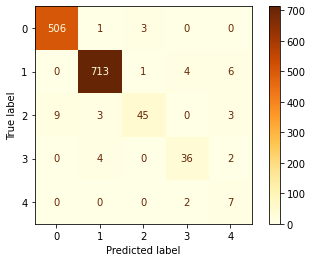

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       510
           1       0.99      0.98      0.99       724
           2       0.92      0.75      0.83        60
           3       0.86      0.86      0.86        42
           4       0.39      0.78      0.52         9

    accuracy                           0.97      1345
   macro avg       0.83      0.87      0.84      1345
weighted avg       0.98      0.97      0.97      1345

### 0 Anomaly / 1 Normal ###


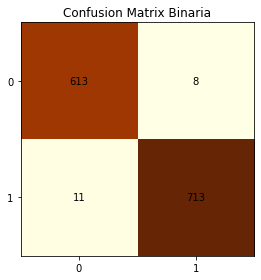

          predicted labels  
0 :
             precision:  0.982
             recall:     0.987


1 :
             precision:  0.989
             recall:     0.985


Avg precision:     0.986
Avg weight precision:     0.986
Avg recall:     0.986
Avg weight recall:     0.986

Accuracy:  0.98587
Il dataset per il train è composto da :  12106 record
Peso associato alla classe 0, Dos: 0.54
Peso associato alla classe 1, Normal: 0.36
Peso associato alla classe 2, Probe: 5.12
Peso associato alla classe 3, R2L: 6.94
Peso associato alla classe 4, U2R: 49.41
Epoch 1/30
48/48 [==============================] - 6s 135ms/step - loss: 6.1127 - accuracy: 0.3265 - val_loss: 3.8528 - val_accuracy: 0.4050
Epoch 2/30
48/48 [==============================] - 6s 131ms/step - loss: 3.2595 - accuracy: 0.7378 - val_loss: 2.5180 - val_accuracy: 0.4250
Epoch 3/30
48/48 [==============================] - 7s 136ms/step - loss: 2.1852 - accuracy: 0.8557 - val_loss: 1.4291 - val_accuracy: 0.9450
Epoch 4/30
48/48 [===

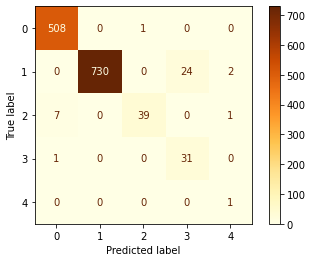

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       509
           1       1.00      0.97      0.98       756
           2       0.97      0.83      0.90        47
           3       0.56      0.97      0.71        32
           4       0.25      1.00      0.40         1

    accuracy                           0.97      1345
   macro avg       0.75      0.95      0.80      1345
weighted avg       0.98      0.97      0.98      1345

### 0 Anomaly / 1 Normal ###


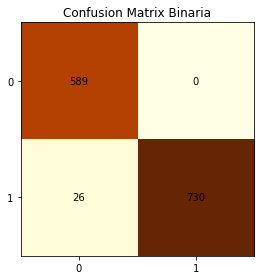

          predicted labels  
0 :
             precision:  0.958
             recall:     1.000


1 :
             precision:  1.000
             recall:     0.966


Avg precision:     0.979
Avg weight precision:     0.981
Avg recall:     0.983
Avg weight recall:     0.981

Accuracy:  0.98067
Il dataset per il train è composto da :  12106 record
Peso associato alla classe 0, Dos: 0.54
Peso associato alla classe 1, Normal: 0.36
Peso associato alla classe 2, Probe: 5.10
Peso associato alla classe 3, R2L: 6.96
Peso associato alla classe 4, U2R: 52.63
Epoch 1/30
48/48 [==============================] - 6s 134ms/step - loss: 6.9757 - accuracy: 0.4389 - val_loss: 4.1823 - val_accuracy: 0.4200
Epoch 2/30
48/48 [==============================] - 7s 136ms/step - loss: 3.1612 - accuracy: 0.7163 - val_loss: 2.0358 - val_accuracy: 0.9450
Epoch 3/30
48/48 [==============================] - 6s 132ms/step - loss: 2.0951 - accuracy: 0.8747 - val_loss: 1.1631 - val_accuracy: 0.9500
Epoch 4/30
48/48 [===

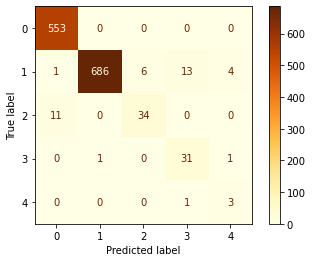

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       553
           1       1.00      0.97      0.98       710
           2       0.85      0.76      0.80        45
           3       0.69      0.94      0.79        33
           4       0.38      0.75      0.50         4

    accuracy                           0.97      1345
   macro avg       0.78      0.88      0.81      1345
weighted avg       0.98      0.97      0.97      1345

### 0 Anomaly / 1 Normal ###


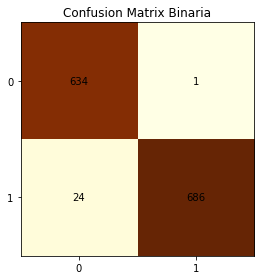

          predicted labels  
0 :
             precision:  0.964
             recall:     0.998


1 :
             precision:  0.999
             recall:     0.966


Avg precision:     0.981
Avg weight precision:     0.982
Avg recall:     0.982
Avg weight recall:     0.981

Accuracy:  0.98141
Il dataset per il train è composto da :  12106 record
Peso associato alla classe 0, Dos: 0.54
Peso associato alla classe 1, Normal: 0.36
Peso associato alla classe 2, Probe: 5.32
Peso associato alla classe 3, R2L: 7.10
Peso associato alla classe 4, U2R: 52.63
Epoch 1/30
48/48 [==============================] - 7s 138ms/step - loss: 4.5804 - accuracy: 0.3986 - val_loss: 2.5915 - val_accuracy: 0.8750
Epoch 2/30
48/48 [==============================] - 6s 134ms/step - loss: 2.4402 - accuracy: 0.7989 - val_loss: 1.4802 - val_accuracy: 0.6550
Epoch 3/30
48/48 [==============================] - 7s 154ms/step - loss: 1.7998 - accuracy: 0.8258 - val_loss: 0.8665 - val_accuracy: 0.9500
Epoch 4/30
48/48 [===

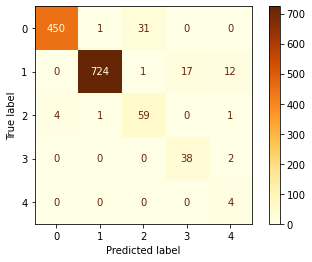

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       482
           1       1.00      0.96      0.98       754
           2       0.65      0.91      0.76        65
           3       0.69      0.95      0.80        40
           4       0.21      1.00      0.35         4

    accuracy                           0.95      1345
   macro avg       0.71      0.95      0.77      1345
weighted avg       0.97      0.95      0.95      1345

### 0 Anomaly / 1 Normal ###


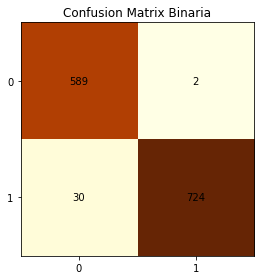

          predicted labels  
0 :
             precision:  0.952
             recall:     0.997


1 :
             precision:  0.997
             recall:     0.960


Avg precision:     0.974
Avg weight precision:     0.977
Avg recall:     0.978
Avg weight recall:     0.976

Accuracy:  0.97621
Il dataset per il train è composto da :  12106 record
Peso associato alla classe 0, Dos: 0.54
Peso associato alla classe 1, Normal: 0.36
Peso associato alla classe 2, Probe: 5.16
Peso associato alla classe 3, R2L: 7.04
Peso associato alla classe 4, U2R: 51.51
Epoch 1/30
48/48 [==============================] - 7s 139ms/step - loss: 4.5300 - accuracy: 0.3085 - val_loss: 2.4874 - val_accuracy: 0.9500
Epoch 2/30
48/48 [==============================] - 6s 135ms/step - loss: 2.5667 - accuracy: 0.7734 - val_loss: 1.2823 - val_accuracy: 0.9400
Epoch 3/30
48/48 [==============================] - 6s 133ms/step - loss: 1.3315 - accuracy: 0.8692 - val_loss: 2.0349 - val_accuracy: 0.7900
Epoch 4/30
48/48 [===

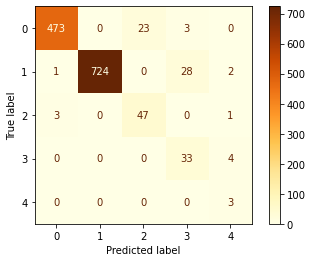

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       499
           1       1.00      0.96      0.98       755
           2       0.67      0.92      0.78        51
           3       0.52      0.89      0.65        37
           4       0.30      1.00      0.46         3

    accuracy                           0.95      1345
   macro avg       0.70      0.94      0.77      1345
weighted avg       0.97      0.95      0.96      1345

### 0 Anomaly / 1 Normal ###


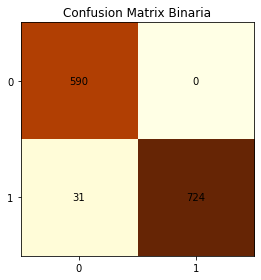

          predicted labels  
0 :
             precision:  0.950
             recall:     1.000


1 :
             precision:  1.000
             recall:     0.959


Avg precision:     0.975
Avg weight precision:     0.978
Avg recall:     0.979
Avg weight recall:     0.977

Accuracy:  0.97695


In [42]:
y = data_final[94]
x = data_final.drop([94], axis=1)

x_np = np.asarray(x).astype(np.float32)
y_np = np.asarray(y).astype(np.float32)

kfold = KFold(n_splits=10, shuffle=True, random_state=32)

for train, test in kfold.split(x_np, y_np):
    x_train, x_test = x_np[train], x_np[test]
    y_train, y_test = y_np[train], y_np[test]
    
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    val_indices = 200
    x_val = x_train[-val_indices:]
    y_val = y_train[-val_indices:]
    
    num_train = len(x_train)
    num_train_normal = 0
    num_train_dos = 0
    num_train_r2l = 0
    num_train_u2r = 0
    num_train_probe = 0

    print("Il dataset per il train è composto da : ",num_train,"record")

    for i in y_train:
        if(i[0] == 1):
            num_train_dos = num_train_dos + 1
        if(i[1] == 1):
            num_train_normal = num_train_normal + 1
        if(i[2] == 1):
            num_train_probe = num_train_probe + 1
        if(i[3] == 1):
            num_train_r2l = num_train_r2l + 1
        if(i[4] == 1):
            num_train_u2r = num_train_u2r + 1
    
    total = num_train

    weight_for_0 = (1 / num_train_dos)*(total)/5.0 
    weight_for_1 = (1 / num_train_normal)*(total)/5.0
    weight_for_2 = (1 / num_train_probe)*(total)/5.0
    weight_for_3 = (1 / num_train_r2l)*(total)/5.0
    weight_for_4 = (1 / num_train_u2r)*(total)/5.0

    class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4}

    print('Peso associato alla classe 0, Dos: {:.2f}'.format(weight_for_0))
    print('Peso associato alla classe 1, Normal: {:.2f}'.format(weight_for_1))
    print('Peso associato alla classe 2, Probe: {:.2f}'.format(weight_for_2))
    print('Peso associato alla classe 3, R2L: {:.2f}'.format(weight_for_3))
    print('Peso associato alla classe 4, U2R: {:.2f}'.format(weight_for_4))
    
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_dim=x_train.shape[1], kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    history=model.fit(x_train,
          y_train,
          epochs=30,
          batch_size=256,
          validation_data=(x_val, y_val),
          class_weight=class_weight
         )
    
    y_pred = model.predict(x_test)
    
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    
    conf_matrix = confusion_matrix(y_test, y_pred)

    # 0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

    print("Il classificatore ha predetto in totale", 
          conf_matrix[0][0]+conf_matrix[1][0]+conf_matrix[2][0]+conf_matrix[3][0]+conf_matrix[4][0],
          "record Dos di cui",conf_matrix[0][0],"corretti(TP),",
          conf_matrix[1][0]+conf_matrix[2][0]+conf_matrix[3][0]+conf_matrix[4][0],
          "predetti erroneamente(FP),",
          conf_matrix[0][1]+conf_matrix[0][2]+conf_matrix[0][3]+conf_matrix[0][4],
          "record Dos reali predetti in altri attacchi (FN)"
         )
    print("")
    print("Il classificatore ha predetto in totale", 
          conf_matrix[0][1]+conf_matrix[1][1]+conf_matrix[2][1]+conf_matrix[3][1]+conf_matrix[4][1],
          "record Normali di cui",conf_matrix[1][1],"corretti(TP),",
          conf_matrix[0][1]+conf_matrix[2][1]+conf_matrix[3][1]+conf_matrix[4][1],
          "predetti erroneamente(FP),",
          conf_matrix[1][0]+conf_matrix[1][2]+conf_matrix[1][3]+conf_matrix[1][4],
          "record Normali reali predetti in altri attacchi (FN)"
         )
    print("")
    print("Il classificatore ha predetto in totale", 
          conf_matrix[0][2]+conf_matrix[1][2]+conf_matrix[2][2]+conf_matrix[3][2]+conf_matrix[4][2],
          "record Probe di cui",conf_matrix[2][2],"corretti(TP),",
          conf_matrix[0][2]+conf_matrix[1][2]+conf_matrix[3][2]+conf_matrix[4][2],
          "predetti erroneamente(FP),",
          conf_matrix[2][0]+conf_matrix[2][1]+conf_matrix[2][3]+conf_matrix[2][4],
          "record Probe reali predetti in altri attacchi (FN)"
         )
    print("")
    print("Il classificatore ha predetto in totale", 
          conf_matrix[0][3]+conf_matrix[1][3]+conf_matrix[2][3]+conf_matrix[3][3]+conf_matrix[4][3],
          "record R2L di cui",conf_matrix[3][3],"corretti(TP),",
          conf_matrix[0][3]+conf_matrix[1][3]+conf_matrix[2][3]+conf_matrix[4][3],
          "predetti erroneamente(FP),",
          conf_matrix[3][0]+conf_matrix[3][1]+conf_matrix[3][2]+conf_matrix[3][4],
          "record R2L reali predetti in altri attacchi (FN)"
         )
    print("")
    print("Il classificatore ha predetto in totale", 
          conf_matrix[0][4]+conf_matrix[1][4]+conf_matrix[2][4]+conf_matrix[3][4]+conf_matrix[4][4],
          "record U2R di cui",conf_matrix[4][4],"corretti(TP),",
          conf_matrix[0][4]+conf_matrix[1][4]+conf_matrix[2][4]+conf_matrix[3][4],
          "predetti erroneamente(FP),",
          conf_matrix[4][0]+conf_matrix[4][1]+conf_matrix[4][2]+conf_matrix[4][3],
          "record U2R reali predetti in altri attacchi (FN)"
         )

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    disp = disp.plot(cmap='YlOrBr')

    plt.show()
    print("0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r")
    print("")
    print(classification_report(y_test, y_pred))
    
    #Calcolo a posteriori la rispettiva matrice di confusione binaria associata alla precedente

    #num_test_normal / num_test_dos etc . . .
    # 1 è normal mentre 0 2 3 4 sono anomalies

    #Record normali classificati come normali (TP)

    true_positive = conf_matrix[1][1]

    #record anomali classificati come anomali (TN)

    true_negative = (conf_matrix[0][0] + conf_matrix[0][2] + conf_matrix[0][3] + conf_matrix[0][4] +
                    + conf_matrix[2][0] + conf_matrix[2][2] + conf_matrix[2][3] + conf_matrix[2][4] 
                    + conf_matrix[3][0] + conf_matrix[3][2] + conf_matrix[3][3] + conf_matrix[3][4] 
                    + conf_matrix[4][0] + conf_matrix[4][2] + conf_matrix[4][3] + conf_matrix[4][4])
            
    #record normali classificati come anomali (FN)

    false_negative = conf_matrix[1][0] + conf_matrix[1][2] + conf_matrix[1][3] + conf_matrix[1][4]

    #record anomali classificati come normali (FP)

    false_positive = conf_matrix[0][1] + conf_matrix[2][1] + conf_matrix[3][1] + conf_matrix[4][1]

    indici_riga_colonna = ['0','1']


    values = np.array([[true_negative, false_positive],
                   [false_negative, true_positive]])

    fig, ax = plt.subplots()
    im = ax.imshow(values, cmap='YlOrBr')

    ax.set_xticks(np.arange(len(indici_riga_colonna)))
    ax.set_yticks(np.arange(len(indici_riga_colonna)))

    ax.set_xticklabels(indici_riga_colonna)
    ax.set_yticklabels(indici_riga_colonna)

    plt.setp(ax.get_xticklabels(),
             rotation_mode="anchor")

    for i in range(len(indici_riga_colonna)):
        for j in range(len(indici_riga_colonna)):
            text = ax.text(j, i, values[i, j],
                           ha="center", va="center")

    ax.set_title("Confusion Matrix Binaria")
    fig.tight_layout()

    print("### 0 Anomaly / 1 Normal ###")
    plt.show()

    print("          predicted labels  ")
    
    zero_precision = true_negative/(true_negative + false_negative) 
    one_precision = true_positive/(true_positive + false_positive) 

    zero_recall = true_negative/(true_negative + false_positive)
    one_recall = true_positive/(true_positive + false_negative)

    accuracy= (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative)
    print("0 :")
    print("             precision: ","%.3f" % zero_precision)
    print("             recall: ","   %.3f" % zero_recall)
    print("")
    print("")
    print("1 :")
    print("             precision: ","%.3f" % one_precision)
    print("             recall: ","   %.3f" % one_recall)
    print("")
    print("")
    avg_precision = (zero_precision + one_precision)/2
    avg_precision_weight = (zero_precision*(true_negative+false_positive) + one_precision*(false_negative + true_positive))/(true_negative + false_positive + false_negative + true_positive)
    avg_recall = (zero_recall + one_recall)/2
    avg_recall_weight = (zero_recall*(true_negative+false_positive) + one_recall*(false_negative + true_positive))/(true_negative + false_positive + false_negative + true_positive)
    print("Avg precision: ","   %.3f" % avg_precision)
    print("Avg weight precision: ","   %.3f" % avg_precision_weight)
    print("Avg recall: ","   %.3f" % avg_recall)
    print("Avg weight recall: ","   %.3f" % avg_recall_weight)
    print("")
    print("Accuracy: ", "%.5f" % accuracy)